In [27]:
# System operations
import inspect
import os
import uuid

# Date and time
from datetime import datetime

# type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

# User interaction
from IPython.display import clear_output
from ipywidgets import Button, FloatSlider, HBox, HTML
from ipywidgets import IntProgress, Text, VBox

# Data manipulation
from bs4 import BeautifulSoup
import math
import numpy as np
import pandas as pd
import gym
from gym import spaces
import random
import re
import requests
import simplejson as json

# CityLearn
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper
from citylearn.wrappers import TabularQLearningWrapper

# baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv

In [28]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

In [29]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'
schema = DataSet.get_schema(DATASET_NAME)

In [30]:
# Building
root_directory = schema['root_directory']

# change the suffix number in the next code line to a
building_name = 'Building_1'

filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())
display(building_data.describe(include='all'))
# 2208 entries = 24 hours * 30,67 days * 3 months
# months: 6, 7, 8 = June, July, August
# hours: 1, 2, ..., 24

,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature (C),Average Unmet Cooling Setpoint Difference (C),Indoor Relative Humidity (%),Equipment Electric Power (kWh),DHW Heating (kWh),Cooling Load (kWh),Heating Load (kWh),Solar Generation (W/kW),Occupant Count (people),Temperature Set Point (C),HVAC Mode (Off/Cooling/Heating)
0,6,1,2,0,22.428127,-0.794095,78.008001,0.356269,0.055730,0.000000,0.0,0.0,3.0,23.222222,1
1,6,2,2,0,22.223214,0.000992,79.042718,0.344522,0.159217,0.227737,0.0,0.0,3.0,22.222222,1
2,6,3,2,0,22.222226,0.000004,79.337523,0.338227,0.056899,0.132294,0.0,0.0,3.0,22.222222,1
3,6,4,2,0,22.222226,0.000004,79.581156,0.334329,0.000000,0.152979,0.0,0.0,3.0,22.222222,1
4,6,5,2,0,22.222226,0.000003,79.783525,0.348094,0.000000,0.119001,0.0,0.0,3.0,22.222222,1


,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature (C),Average Unmet Cooling Setpoint Difference (C),Indoor Relative Humidity (%),Equipment Electric Power (kWh),DHW Heating (kWh),Cooling Load (kWh),Heating Load (kWh),Solar Generation (W/kW),Occupant Count (people),Temperature Set Point (C),HVAC Mode (Off/Cooling/Heating)
count,2208.000000,2208.000000,2208.000000,2208.0,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.0,2208.000000,2208.000000,2208.000000,2208.0
mean,7.010870,12.500000,3.978261,0.0,24.127535,-0.018776,59.200654,0.611653,0.203282,2.832108,0.0,181.965621,2.285326,24.146311,1.0
std,0.814387,6.923755,2.000335,0.0,1.210651,0.171864,4.966167,0.814862,0.438131,1.643799,0.0,228.982415,0.846712,1.219651,0.0
min,6.000000,1.000000,1.000000,0.0,20.000008,-2.543717,45.069613,0.308113,0.000000,0.000000,0.0,0.000000,0.000000,20.000000,1.0
25%,6.000000,6.750000,2.000000,0.0,23.333403,-0.000026,56.135186,0.354607,0.000000,1.775248,0.0,0.000000,2.000000,23.333333,1.0
50%,7.000000,12.500000,4.000000,0.0,24.444372,0.000007,58.611239,0.403186,0.000000,2.550615,0.0,27.846772,3.000000,24.444444,1.0
75%,8.000000,18.250000,6.000000,0.0,24.444454,0.000090,61.912185,0.522546,0.203143,3.610280,0.0,388.286173,3.000000,24.444444,1.0
max,8.000000,24.000000,7.000000,0.0,27.222278,0.172056,80.558754,7.458969,4.529509,10.852755,0.0,712.919243,3.000000,27.222222,1.0


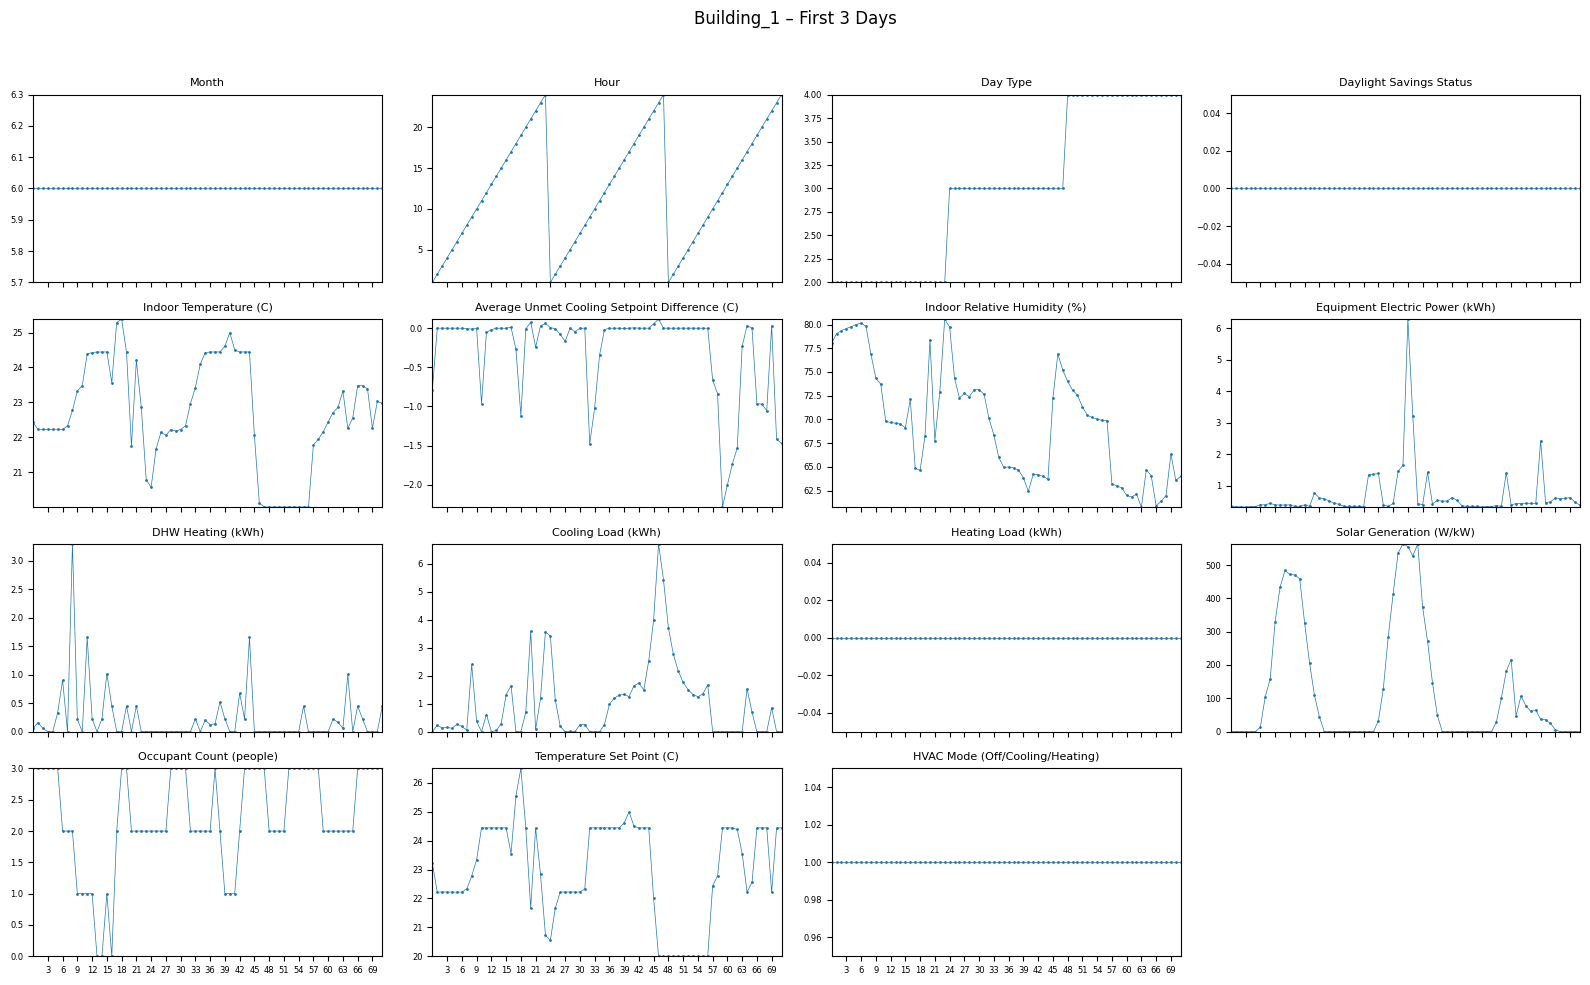

'Building Data\nMonth: 6 = June, 7 = July, 8 = August\nHour: 1 - 24h\nDay Type: 1 = Monday, ..., 7 = Sunday\nDaylight Savings Status: 1 = Summertime, 0 = Wintertime\nIndoor Temperature (C): good = 20 - 24°C \nAverage Unmet Cooling Setpoint Difference (C): 0 = no difference, < 0 = cooling needed\nIndoor Relative Humidity (%): good = 30 - 60%\nEquipment Electric Power (kWh): Electric power consumption of all equipment in the building in that hour\nDHW Heating (kWh): Energy used for domestic hot water\nCooling Load (kWh): Energy used for cooling \nHeating Load (kWh): Energy used for heating\nSolar Generation (W/kW): PV output per kW of installed capacity\nOccupant Count (people): Number of people in the building\nTemperature Set Point (C): Target temperature for heating/cooling control\nHVAC Mode (Off/Cooling/Heating): Operating state (0 = Off, 1 = Cooling, 2 = Heating) - always 1 in this dataset\n--------\nObservations\n- Indoor Temp rises from ~22 °C at night to ~24.5 °C by mid-afternoo

In [31]:
hours = 72
first_ndays = building_data.iloc[:hours]

features = building_data.columns.tolist()
n_features = len(features)
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 2.5*n_rows), sharex=True)
axes = axes.flatten()

for ax, feat in zip(axes, features):
    ax.plot(first_ndays.index, first_ndays[feat], marker='o', markersize=1, linewidth=0.5)
    ax.set_title(feat, fontsize=8)
    ax.tick_params(labelsize=6, rotation=0)


# hide empty subplots
for ax in axes[n_features:]:
    ax.set_visible(False)

fig.suptitle(f'{building_name} – First 3 Days', fontsize=12)
# set xlabel every 3 hours
ticks = list(range(3, hours, 3))
for ax in axes[-n_cols:]: 
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
"""Building Data
Month: 6 = June, 7 = July, 8 = August
Hour: 1 - 24h
Day Type: 1 = Monday, ..., 7 = Sunday
Daylight Savings Status: 1 = Summertime, 0 = Wintertime
Indoor Temperature (C): good = 20 - 24°C 
Average Unmet Cooling Setpoint Difference (C): 0 = no difference, < 0 = cooling needed
Indoor Relative Humidity (%): good = 30 - 60%
Equipment Electric Power (kWh): Electric power consumption of all equipment in the building in that hour
DHW Heating (kWh): Energy used for domestic hot water
Cooling Load (kWh): Energy used for cooling 
Heating Load (kWh): Energy used for heating
Solar Generation (W/kW): PV output per kW of installed capacity
Occupant Count (people): Number of people in the building
Temperature Set Point (C): Target temperature for heating/cooling control
HVAC Mode (Off/Cooling/Heating): Operating state (0 = Off, 1 = Cooling, 2 = Heating) - always 1 in this dataset
--------
Observations
- Indoor Temp rises from ~22 °C at night to ~24.5 °C by mid-afternoon, then falls again.
- HVAC is always in cooling mode, even when indoor temperature is below set-point or no one’s home.
- Equipment Electric Power and Cooling Load spike sharply mid day, at night almost zero load.
- DHW heating spikes around 6 am, irregular spikes in the afternoon.
- Solar generation bell curve, Day 3 probably cloudy. Covers some midday cooling demand but drops to zero at night.
- Cooling reduces Indoor Relative Humidity noticeably.
- Average Unmet Cooling Difference hovers at 0 °C (set-point met), with occasional –1 to –2 °C dips when the system can’t keep up.
- No heating at all (June)
--------
Improvements
- Switch HVAC off overnight
- Align DHW cycles with solar peaks
- Adjust set-points when the building is unoccupied.
"""

In [32]:
# Weather
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
display(weather_data.head())
display(weather_data.describe(include='all'))

,Outdoor Drybulb Temperature (C),Outdoor Relative Humidity (%),Diffuse Solar Radiation (W/m2),Direct Solar Radiation (W/m2),6h Outdoor Drybulb Temperature (C),12h Outdoor Drybulb Temperature (C),24h Outdoor Drybulb Temperature (C),6h Outdoor Relative Humidity (%),12h Outdoor Relative Humidity (%),24h Outdoor Relative Humidity (%),6h Diffuse Solar Radiation (W/m2),12h Diffuse Solar Radiation (W/m2),24h Diffuse Solar Radiation (W/m2),6h Direct Solar Radiation (W/m2),12h Direct Solar Radiation (W/m2),24h Direct Solar Radiation (W/m2)
0,21.85,98.19,0.0,0.0,21.732718,26.866080,17.422408,93.976727,69.354652,100.000000,31.002763,558.888038,0.0,33.498174,206.749269,0.0
1,21.38,98.50,0.0,0.0,20.411549,27.594865,18.847815,100.000000,66.378445,58.537117,126.091537,353.877800,0.0,56.405338,156.532802,0.0
2,21.09,98.50,0.0,0.0,21.200410,25.718458,18.877053,83.317789,65.566978,98.343583,156.312134,568.664419,0.0,73.175290,218.931168,0.0
3,20.94,98.00,0.0,0.0,21.554139,28.057227,18.871671,79.531618,60.264404,100.000000,270.416851,229.660028,0.0,177.545001,183.774540,0.0
4,20.82,97.88,0.0,0.0,23.526414,25.909586,18.416461,61.784273,81.097343,100.000000,496.742911,182.760709,0.0,175.074447,85.399140,0.0


,Outdoor Drybulb Temperature (C),Outdoor Relative Humidity (%),Diffuse Solar Radiation (W/m2),Direct Solar Radiation (W/m2),6h Outdoor Drybulb Temperature (C),12h Outdoor Drybulb Temperature (C),24h Outdoor Drybulb Temperature (C),6h Outdoor Relative Humidity (%),12h Outdoor Relative Humidity (%),24h Outdoor Relative Humidity (%),6h Diffuse Solar Radiation (W/m2),12h Diffuse Solar Radiation (W/m2),24h Diffuse Solar Radiation (W/m2),6h Direct Solar Radiation (W/m2),12h Direct Solar Radiation (W/m2),24h Direct Solar Radiation (W/m2)
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,27.980050,73.417101,97.882654,218.469982,27.953409,27.956736,28.021356,72.463963,71.803247,70.592483,97.807395,96.942329,98.441871,218.772299,220.481199,217.888001
std,4.230285,20.180751,117.204151,269.103317,4.286196,4.347976,4.397015,20.835967,21.229588,22.715702,118.862715,118.419787,123.270883,272.479175,277.982015,279.540165
min,18.160000,23.000000,0.000000,0.000000,17.735878,18.267269,17.025523,21.950264,20.977084,14.766615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.597500,56.295000,0.000000,0.000000,24.545485,24.546243,24.681678,55.080711,55.232968,52.281086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.065000,77.120000,54.255000,62.575000,26.992833,27.090329,27.188440,76.034532,73.076987,70.151863,52.501282,49.901991,48.236602,62.762048,62.022108,58.296668
75%,31.332500,92.380000,173.935000,432.290000,31.315535,31.420868,31.262254,90.653620,91.152023,93.375349,174.192444,169.885758,170.899417,423.484433,418.632038,401.765695
max,38.110000,100.000000,500.840000,918.620000,38.912340,38.959303,39.400984,100.000000,100.000000,100.000000,569.772493,577.359650,632.892221,1069.393245,1161.951164,1178.477829


C:\Users\johann\AppData\Local\Temp\ipykernel_32336\786360300.py:34: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.12)


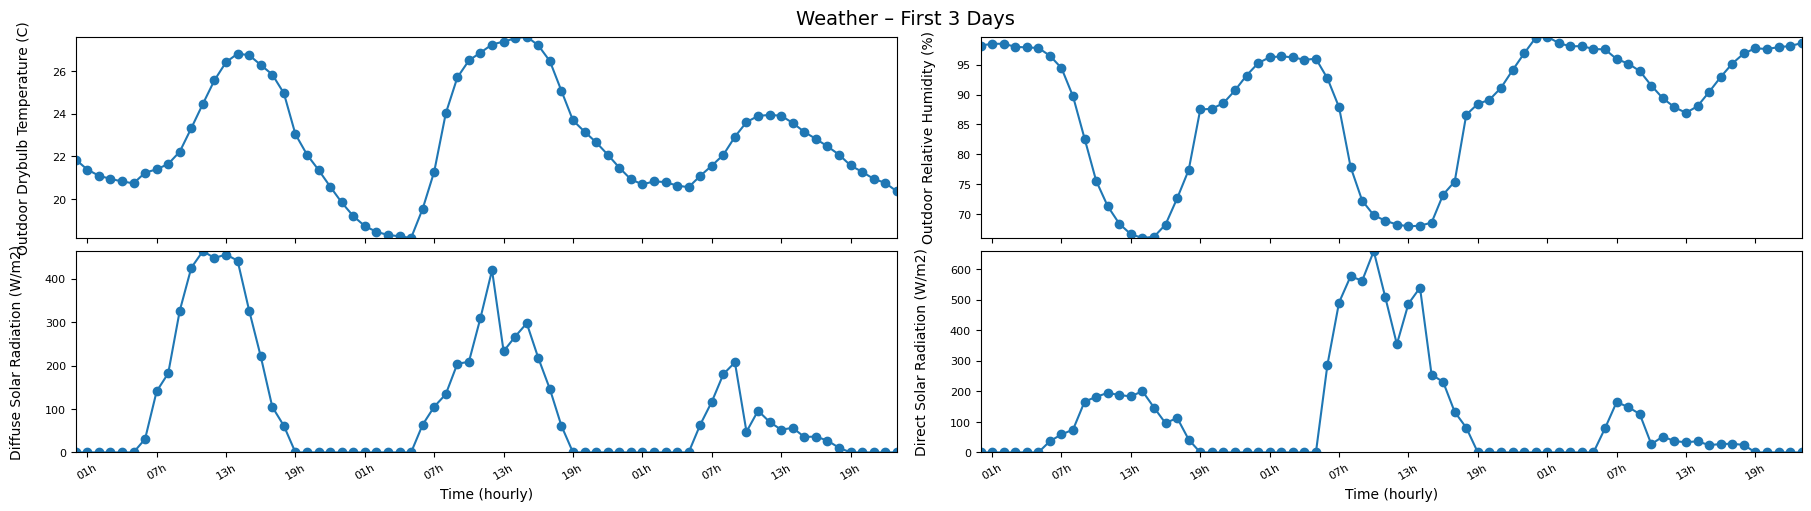

In [33]:
weather_data.index = pd.date_range(
    start='2023-06-01 00:00',
    periods=len(weather_data),
    freq='H'
)

first_ndays = weather_data.iloc[:72]

columns = [
    'Outdoor Drybulb Temperature (C)', 
    'Outdoor Relative Humidity (%)',
    'Diffuse Solar Radiation (W/m2)', 
    'Direct Solar Radiation (W/m2)'
]

fig, axs = plt.subplots(
    2, 2,
    figsize=(18, 5),
    sharex=True,
    constrained_layout=True
)
for ax, col in zip(axs.flatten(), columns):
    ax.plot(first_ndays.index, first_ndays[col], marker='o')
    ax.set_ylabel(col, labelpad=15, fontsize=10)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Hh'))
    ax.tick_params(axis='x', rotation=30, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

for ax in axs[1]:
    ax.set_xlabel('Time (hourly)', fontsize=10)

fig.suptitle('Weather – First 3 Days', fontsize=14)
fig.subplots_adjust(left=0.12)

plt.show()

In [34]:
# Pricing (simple)
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
display(pricing_data.head())
display(pricing_data.describe(include='all'))

,Electricity Pricing [$/kWh],6h Prediction Electricity Pricing [$/kWh],12h Prediction Electricity Pricing [$/kWh],24h Prediction Electricity Pricing [$/kWh]
0,0.03025,0.03025,0.03025,0.03025
1,0.03025,0.03025,0.03025,0.03025
2,0.03025,0.03025,0.03025,0.03025
3,0.03025,0.03025,0.06605,0.03025
4,0.03025,0.03025,0.06605,0.03025


,Electricity Pricing [$/kWh],6h Prediction Electricity Pricing [$/kWh],12h Prediction Electricity Pricing [$/kWh],24h Prediction Electricity Pricing [$/kWh]
count,2208.000000,2208.000000,2208.000000,2208.000000
mean,0.033460,0.033460,0.033460,0.033460
std,0.010231,0.010231,0.010231,0.010231
min,0.030250,0.030250,0.030250,0.030250
25%,0.030250,0.030250,0.030250,0.030250
50%,0.030250,0.030250,0.030250,0.030250
75%,0.030250,0.030250,0.030250,0.030250
max,0.066050,0.066050,0.066050,0.066050


Another supplementary data is the grid carbon intensity time series describing the CO<sub>2</sub> equivalent of greenhouse gases that are emitted for every unit kWh of energy consumption. This carbon intensity data were provided by EPRI and the time series is shown with its summary statistics below:

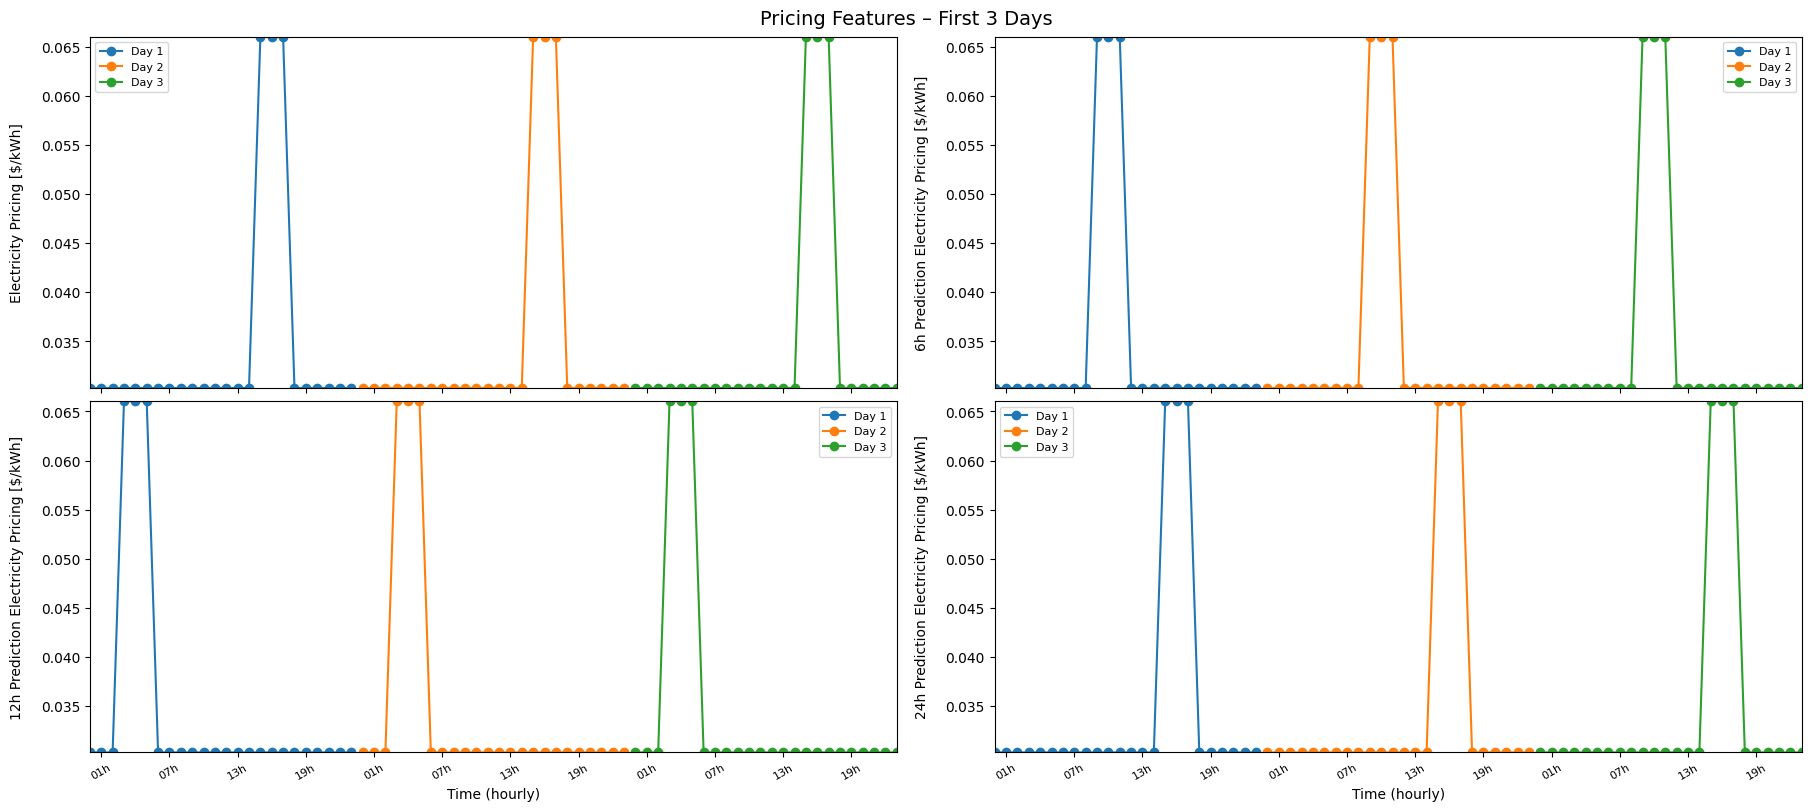

In [35]:
pricing_data.index = pd.date_range(start='2023-06-01 00:00', periods=len(pricing_data), freq='H')
first_3days   = pricing_data.iloc[:24 * 3]
day_slices    = [first_3days.iloc[i*24:(i+1)*24] for i in range(3)]
features      = first_3days.columns.tolist()

fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True, constrained_layout=True)

for ax, feat in zip(axs.flatten(), features):
    for i, day in enumerate(day_slices):
        ax.plot(day.index, day[feat], marker='o', label=f'Day {i+1}')
    ax.set_ylabel(feat, labelpad=12)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Hh'))
    ax.tick_params(axis='x', rotation=30, labelsize=8)
    ax.legend(fontsize=8)

fig.suptitle('Pricing Features – First 3 Days', fontsize=14)
for ax in axs[1]:
    ax.set_xlabel('Time (hourly)')
plt.show()

In [36]:
# Carbon Intensity
filename = schema['buildings'][building_name]['carbon_intensity']
filepath = os.path.join(root_directory, filename)
carbon_intensity_data = pd.read_csv(filepath)
display(carbon_intensity_data.head())
display(carbon_intensity_data.describe(include='all').T)

,kg_CO2/kWh
0,0.470113
1,0.467053
2,0.457809
3,0.457264
4,0.461049


,count,mean,std,min,25%,50%,75%,max
kg_CO2/kWh,2208.0,0.438969,0.054517,0.270066,0.397706,0.451167,0.479876,0.563472


We also preview the carbon intensity time series on a pair of axes:

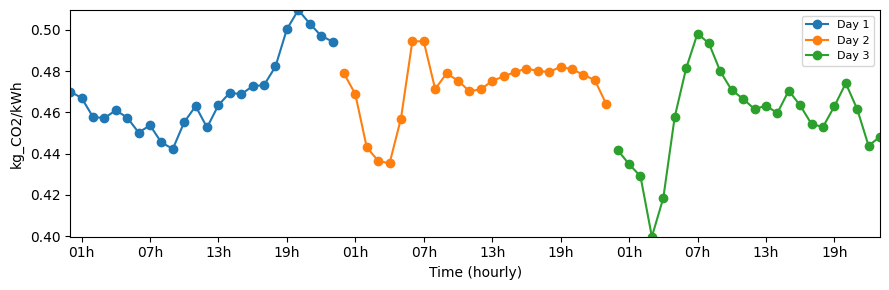

In [37]:
carbon_intensity_data.index = pd.date_range(
    start='2023-06-01 00:00',
    periods=len(carbon_intensity_data),
    freq='H'
)
first_3days_co2 = carbon_intensity_data.iloc[:24 * 3]
day_slices_co2 = [first_3days_co2.iloc[i*24:(i+1)*24] for i in range(3)]

fig, ax = plt.subplots(figsize=(9, 3))
for i, day in enumerate(day_slices_co2):
    ax.plot(day.index, day['kg_CO2/kWh'], marker='o', label=f'Day {i+1}')

ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Hh'))
ax.set_xlabel('Time (hourly)')
ax.set_ylabel('kg_CO2/kWh')
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()
# mid day CO2 emissions are lower than at night/morning, probably due to solar generation

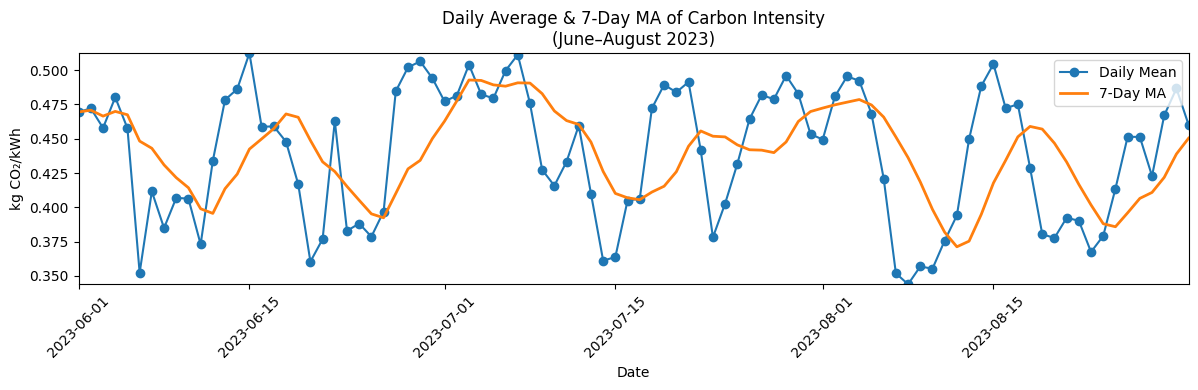

In [38]:
carbon_intensity_data.index = pd.date_range(
    start='2023-06-01 00:00',
    periods=len(carbon_intensity_data),
    freq='H'
)

daily_mean = carbon_intensity_data.resample('D').mean()

rolling7 = daily_mean.rolling(window=7, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(daily_mean.index, daily_mean['kg_CO2/kWh'], marker='o', label='Daily Mean')
ax.plot(rolling7.index,    rolling7['kg_CO2/kWh'], linestyle='-', linewidth=2, label='7-Day MA')
ax.set_xlabel('Date')
ax.set_ylabel('kg CO₂/kWh')
ax.set_title('Daily Average & 7-Day MA of Carbon Intensity\n(June–August 2023)')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

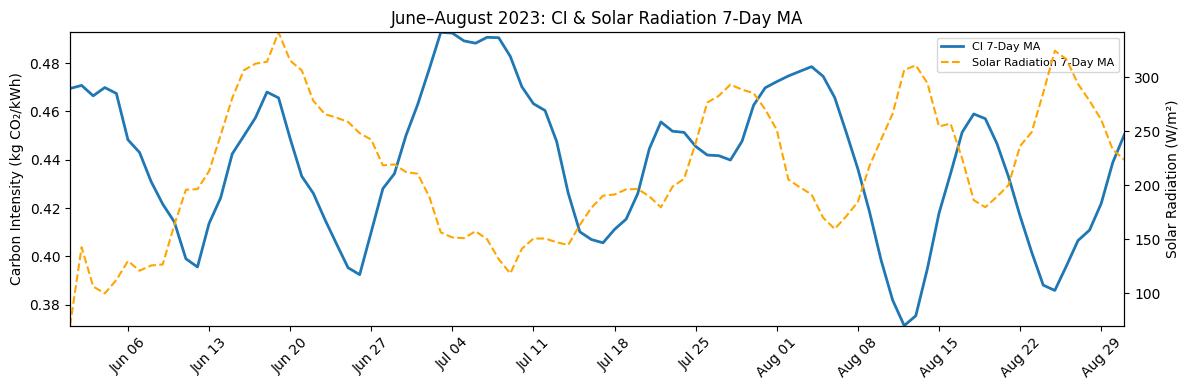

Pearson r = -0.46


<Axes: xlabel='Direct Solar Radiation (W/m2)', ylabel='kg_CO2/kWh'>

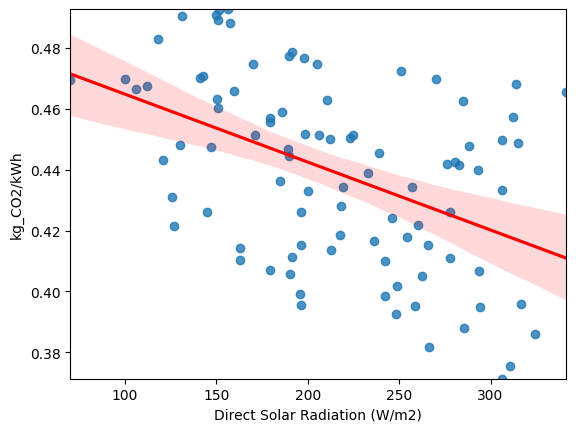

In [39]:
# Carbon Intensity & Solar Radiation
weather_data.index = pd.date_range(start='2023-06-01 00:00', periods=len(weather_data), freq='H')
carbon_intensity_data.index = pd.date_range(start='2023-06-01 00:00', periods=len(carbon_intensity_data), freq='H')

weather_daily = weather_data.resample('D').mean()
carbon_daily  = carbon_intensity_data.resample('D').mean()

carbon_roll7 = carbon_daily['kg_CO2/kWh'].rolling(window=7, min_periods=1).mean()
solar_roll7  = weather_daily['Direct Solar Radiation (W/m2)'].rolling(window=7, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(12, 4))

#ax1.plot(carbon_daily.index, carbon_daily['kg_CO2/kWh'], marker='o', label='CI Daily Mean') # daily mean
ax1.plot(carbon_roll7.index, carbon_roll7, linewidth=2, label='CI 7-Day MA') # 7 day moving average
ax1.set_ylabel('Carbon Intensity (kg CO₂/kWh)')

ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
#ax2.plot(weather_daily.index, weather_daily['Direct Solar Radiation (W/m2)'], marker='s', color='orange', label='Solar Radiation Daily Mean') # daily mean
ax2.plot(solar_roll7.index,  solar_roll7,        linestyle='--', color='orange', label='Solar Radiation 7-Day MA') # 7 day moving average
ax2.set_ylabel('Solar Radiation (W/m²)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right', fontsize=8)

plt.title('June–August 2023: CI & Solar Radiation 7-Day MA')
plt.tight_layout()
plt.show()
corr = solar_roll7.corr(carbon_roll7)
print(f'Pearson r = {corr:.2f}')
# moderate negative correlation between your 7-day MA of solar radiation and carbon intensity
# r=–0.46 means only about 21 % (r²≈0.21) of the day-to-day variance in carbon intensity is 
# linearly explained by solar alone.
sns.regplot(x=solar_roll7, y=carbon_roll7, line_kws={'color':'red'})


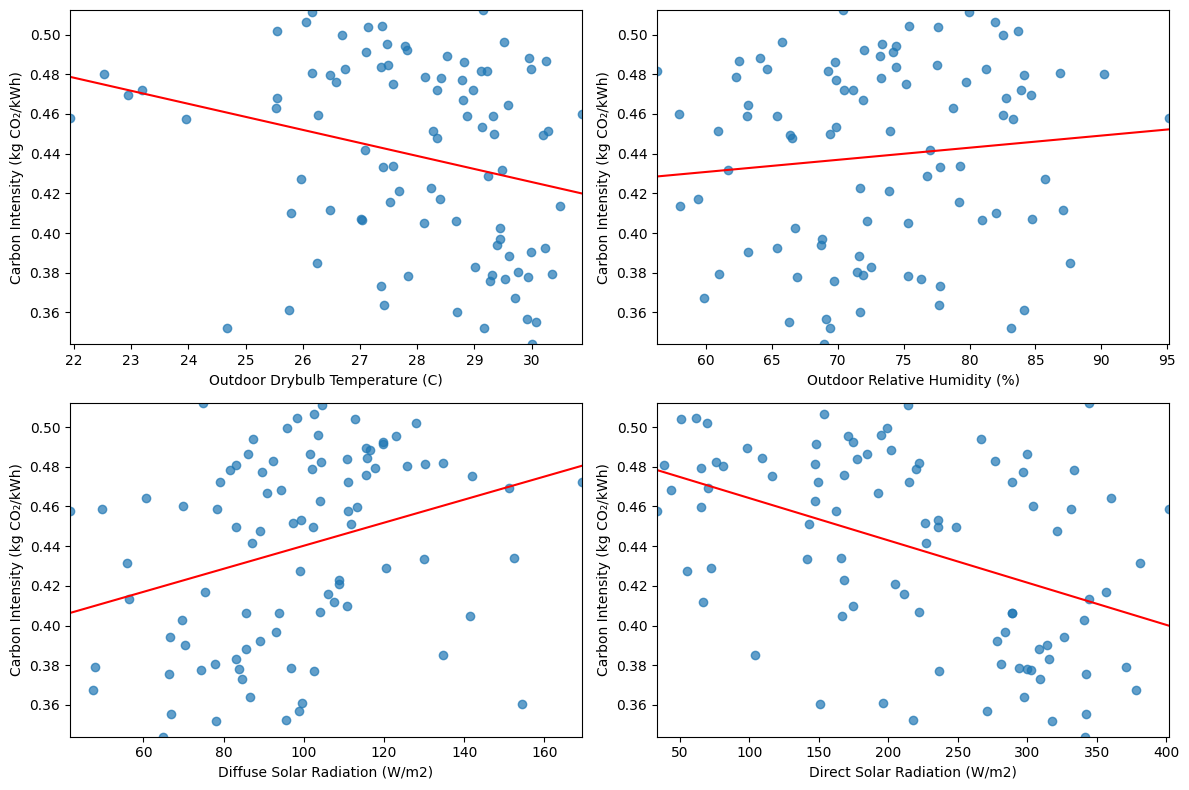

In [40]:
weather_daily = weather_data.resample('D').mean()
carbon_daily = carbon_intensity_data.resample('D').mean()

factors = [
    'Outdoor Drybulb Temperature (C)',
    'Outdoor Relative Humidity (%)',
    'Diffuse Solar Radiation (W/m2)',
    'Direct Solar Radiation (W/m2)'
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, factors):
    x = weather_daily[col]
    y = carbon_daily['kg_CO2/kWh']
    ax.scatter(x, y, alpha=0.7)
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    ax.plot(xs, m*xs + b, color='red')
    ax.set_xlabel(col)
    ax.set_ylabel('Carbon Intensity (kg CO₂/kWh)')

plt.tight_layout()
plt.show()


- **Outdoor Drybulb Temperatue:** Warmer hours often coincide with higher solar generation on the grid, which displaces fossil-fired generation and thus lowers the average carbon intensity.
- **Diffuse radiation** often peaks under partly cloudy conditions. Clouds can temporarily reduce overall solar output even though diffuse is high, so the grid leans on fossil generators, increasing carbon intensity when diffuse is high.
- Strong **direct radiation** corresponds to clear, sunny conditions with maximum solar generation feeding the grid. That displaces dirtier generation the most, so carbon intensity drops when direct solar is high.

Other Influence Factors
- **Total Demand level:** When overall system demand is high, the grid uses higher-emitting power plant, which raises carbon intensity
- **Other renewable energy sources:** wind, hydro and other sources replace fossil generation. More renewable percentage leads to lower carbon intensity
- **Time Of Day:** peak hours lead to higher carbon intensity due to fossil generation being used to satisfy demand

### Deep Q-Learning Agent
1. Wrap the DataFrames in a Gym Environment
Following the same pattern as the tutorial’s Tabular QL wrapper,
but here implement a custom `gym.Env` that emits a vector of normalized
features and accepts a *discrete* charge/discharge action.



In [ ]:
class CustomReward(RewardFunction):
    def __init__(self, capacity: float):
        self.capacity = capacity
        self.prev_net = None

    def __call__(self, obs: Mapping[str, float], action_frac: float) -> float:
        # 1) Net load & cost
        net   = obs['non_shiftable_load'] - action_frac*self.capacity
        price = obs['Electricity Pricing [$/kWh]']
        cost  = max(0.0, net) * price

        # … Komfort-Penalty …
        pen = 0.0
        it, rh = obs['indoor_dry_bulb_temperature'], obs['indoor_relative_humidity']
        if it<20: pen += (20-it)*0.1
        if it>24: pen += (it-24)*0.1
        if rh<30: pen += (30-rh)*0.05
        if rh>60: pen += (rh-60)*0.05

        # … optional: Emissionen, Ramping …
        emis = max(0.0, net) * obs['kg_CO2/kWh']
        if self.prev_net is None:
            ramp = 0.0
        else:
            ramp = abs(net - self.prev_net)
        self.prev_net = net

        # weights
        #w_cost, w_pen, w_emis, w_ramp = 1.0, 2.0, 0.3, 0.1
        # normalize to same scale
        # rework reward function: transform to same scale and test different weights
        # look into Stable Baselines 3 documentation for reward: if it even converges to 0: hat probleme damit bei reward funktionen zu 0 zu konvergieren, maximiert das immer 
        # gegen +/- unendlich
        # workaround: calculate cost without batterie/pv and with it and maximize the difference
        #return -(w_cost*cost + w_pen*pen + w_emis*emis + w_ramp*ramp)
        return -cost 

In [51]:
class CityLearnDQNEnv(gym.Env):
    def __init__(self,
                 building_df: pd.DataFrame,
                 pricing_df:  pd.DataFrame,
                 weather_df:  pd.DataFrame,
                 carbon_df:   pd.DataFrame,
                 n_bins:      int = 5):
        super().__init__()
        self.bld = building_df.reset_index(drop=True)
        self.prc = pricing_df.reset_index(drop=True)
        self.wth = weather_df.reset_index(drop=True)
        self.car = carbon_df.reset_index(drop=True)
        self.T   = len(self.bld)

        self.n_bins     = n_bins
        self.action_space = spaces.Discrete(n_bins)

        self.obs_cols = [
            # aus building_df
            'month', 'hour', 'day_type', 'daylight_savings_status',
            'indoor_dry_bulb_temperature',
            'average_unmet_cooling_setpoint_difference',
            'indoor_relative_humidity',
            'non_shiftable_load', 'dhw_demand',
            'cooling_demand', 'heating_demand',
            'solar_generation', 'occupant_count',
            'temperature_set_point', 'hvac_mode',
            # aus weather_df
            'outdoor_dry_bulb_temperature',
            'outdoor_relative_humidity',
            'diffuse_solar_irradiance',
            'direct_solar_irradiance',
            # aus carbon_df + pricing_df
            'kg_CO2/kWh',
            'Electricity Pricing [$/kWh]'
        ]
        low  = np.zeros(len(self.obs_cols), dtype=np.float32)
        high = np.ones (len(self.obs_cols), dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        # simple battery:
        self.capacity = 1.0
        self.soc      = 0.5
        self.reward_fn = CustomReward(capacity=self.capacity)

    def reset(self):
        self.t   = 0
        self.soc = 0.5
        return self._get_obs()

    def _get_obs(self):
        row = {}
        for c in ['month', 'hour', 'day_type', 'daylight_savings_status',
                  'indoor_dry_bulb_temperature',
                  'average_unmet_cooling_setpoint_difference',
                  'indoor_relative_humidity',
                  'non_shiftable_load', 'dhw_demand',
                  'cooling_demand', 'heating_demand',
                  'solar_generation', 'occupant_count',
                  'temperature_set_point', 'hvac_mode']:
            row[c] = self.bld.loc[self.t, c]

        for c in ['outdoor_dry_bulb_temperature',
                  'outdoor_relative_humidity',
                  'diffuse_solar_irradiance',
                  'direct_solar_irradiance']:
            row[c] = self.wth.loc[self.t, c]

        row['kg_CO2/kWh']               = self.car.loc[self.t, 'kg_CO2/kWh']
        row['Electricity Pricing [$/kWh]'] = self.prc.loc[self.t, 'Electricity Pricing [$/kWh]']

        x = np.array([row[c] for c in self.obs_cols], dtype=np.float32)

        # Normalisierung
        # z.B.
        x[0]  = (x[0] -   1) / 12.0    # month   1–12
        x[1]  = (x[1] -   0) / 23.0    # hour    0–23
        x[2]  = (x[2] -   1) /   6.0    # day_type 1–7
        x[3]  =  x[3].astype(np.float32)   # daylight_savings 0/1
        # … usw. für alle Features …

        return x

    def step(self, action):
        # 1) Aktion → frac
        frac = -1.0 + 2.0 * (action / (self.n_bins - 1))

        # 2) SOC-Update
        self.soc = float(np.clip(self.soc + 0.1 * frac,
                                 0.0, self.capacity))

        # 3) Observation to dict
        obs_dict = {c: self.bld.loc[self.t, c] for c in [
            'non_shiftable_load',
            'indoor_dry_bulb_temperature',
            'indoor_relative_humidity',
        ]}
        # add price
        obs_dict['Electricity Pricing [$/kWh]'] = \
            self.prc.loc[self.t, 'Electricity Pricing [$/kWh]']
        obs_dict['kg_CO2/kWh'] = float(self.car.loc[self.t, 'kg_CO2/kWh'])

        # 4) Calculate Reward 
        reward = self.reward_fn(obs_dict, frac)

        # 5) Increase time and get next observation array
        self.t += 1
        done = (self.t >= self.T)
        obs = self._get_obs() if not done else \
              np.zeros(len(self.obs_cols), dtype=np.float32)

        return obs, reward, done, {}

    def render(self, mode='human'): pass


2. Train a DQN on this Environment
We’ll vectorize with a `DummyVecEnv`, pick `MlpPolicy`, and run for 50 k steps.


In [43]:
# 1) Spalten-Namen angleichen
bld = building_data.copy()
bld = bld.rename(columns={
    'Month': 'month',
    'Hour': 'hour',
    'Day Type': 'day_type',
    'Daylight Savings Status': 'daylight_savings_status',
    'Indoor Temperature (C)': 'indoor_dry_bulb_temperature',
    'Average Unmet Cooling Setpoint Difference (C)': 'average_unmet_cooling_setpoint_difference',
    'Indoor Relative Humidity (%)': 'indoor_relative_humidity',
    'Equipment Electric Power (kWh)': 'non_shiftable_load',
    'DHW Heating (kWh)': 'dhw_demand',
    'Cooling Load (kWh)': 'cooling_demand',
    'Heating Load (kWh)': 'heating_demand',
    'Solar Generation (W/kW)': 'solar_generation',
    'Occupant Count (people)': 'occupant_count',
    'Temperature Set Point (C)': 'temperature_set_point',
    'HVAC Mode (Off/Cooling/Heating)': 'hvac_mode'
})
# Kontroll-Ausgabe
print(bld.columns.tolist())

# 2) Wetterdaten umbenennen (falls nötig)
wth = weather_data.rename(columns={
    'Outdoor Drybulb Temperature (C)': 'outdoor_dry_bulb_temperature',
    'Outdoor Relative Humidity (%)':    'outdoor_relative_humidity',
    'Diffuse Solar Radiation (W/m2)':   'diffuse_solar_irradiance',
    'Direct Solar Radiation (W/m2)':    'direct_solar_irradiance',
})
prc = pricing_data.copy()
car = carbon_intensity_data.copy()


['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 'temperature_set_point', 'hvac_mode']


In [44]:
from stable_baselines3.common.callbacks import BaseCallback
import pandas as pd
import numpy as np

class TrainLoggerCallback(BaseCallback):
    """Loggt State, Action, Reward und Loss während des DQN-Trainings."""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.rows = []
        self.last_loss = np.nan

    def _on_step(self) -> bool:
        # --- 1) Beobachtung und Aktion aus locals ziehen ---
        # bei DQN liegen sie unter diesen keys
        obs    = self.locals["new_obs"]        # shape (1, n_features)
        action = self.locals["actions"]        # shape (1,)
        reward = self.locals["rewards"]        # shape (1,)

        # --- 2) Loss aus dem Policy-Netzwerk holen (nur bei Updates) ---
        # bei DQN wird loss in rollout beendet, im _on_step nach update:
        if "loss" in self.locals:
            self.last_loss = self.locals["loss"]

        # flache Listen daraus machen
        obs = obs.flatten().tolist()
        action = int(action[0])
        reward = float(reward[0])
        loss   = float(self.last_loss)

        # protokollieren
        row = {
            **{f"x{i}": obs[i] for i in range(len(obs))},
            "action": action,
            "reward": reward,
            "loss":   loss,
            "step":   int(self.num_timesteps),
        }
        self.rows.append(row)
        return True

    def _on_training_end(self) -> None:
        # am Ende in ein DataFrame überführen
        self.df = pd.DataFrame(self.rows)
        super()._on_training_end()

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

env = DummyVecEnv([lambda: CityLearnDQNEnv(
    building_df=bld,
    pricing_df=prc,
    weather_df=wth,
    carbon_df=car,
    n_bins=7
)])
# hyperparameter: automatic: grid search, optuner (library for optimizing hyperparameters) (parallel)
callback = TrainLoggerCallback()
model = DQN(
    policy='MlpPolicy',
    env=env,
    learning_rate=1e-3, # 
    buffer_size=20_000, # 
    learning_starts=1_000,
    batch_size=64, #
    tau=1.0,
    gamma=0.99,
    verbose=1,
) 
# look into epsilon 
model.learn(total_timesteps=20_000, callback=callback) #

df = callback.df
df.head()


Using cpu device


c:\Users\johann\anaconda3\envs\citylearn\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 988      |
|    time_elapsed     | 8        |
|    total_timesteps  | 8832     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.271    |
|    n_updates        | 1957     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 854      |
|    time_elapsed     | 20       |
|    total_timesteps  | 17664    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.507    |
|    n_updates        | 4165     |
----------------------------------


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x15,x16,x17,x18,x19,x20,action,reward,loss,step
0,0.416667,0.086957,0.166667,0.0,22.223213,0.000992,79.042717,0.344522,0.159217,0.227737,...,21.379999,98.500000,0.0,0.0,0.467053,0.03025,1,-0.030944,NaN,1
1,0.416667,0.130435,0.166667,0.0,22.222225,0.000004,79.337524,0.338227,0.056899,0.132294,...,21.090000,98.500000,0.0,0.0,0.457809,0.03025,0,-0.040672,NaN,2
2,0.416667,0.173913,0.166667,0.0,22.222227,0.000004,79.581154,0.334329,0.000000,0.152979,...,20.940001,98.000000,0.0,0.0,0.457264,0.03025,6,-0.000000,NaN,3
3,0.416667,0.217391,0.166667,0.0,22.222225,0.000003,79.783524,0.348094,0.000000,0.119001,...,20.820000,97.879997,0.0,0.0,0.461049,0.03025,4,-0.000030,NaN,4
4,0.416667,0.260870,0.166667,0.0,22.222229,0.000007,80.000755,0.346381,0.334883,0.266582,...,20.730000,97.809998,0.0,0.0,0.457513,0.03025,3,-0.010530,NaN,5


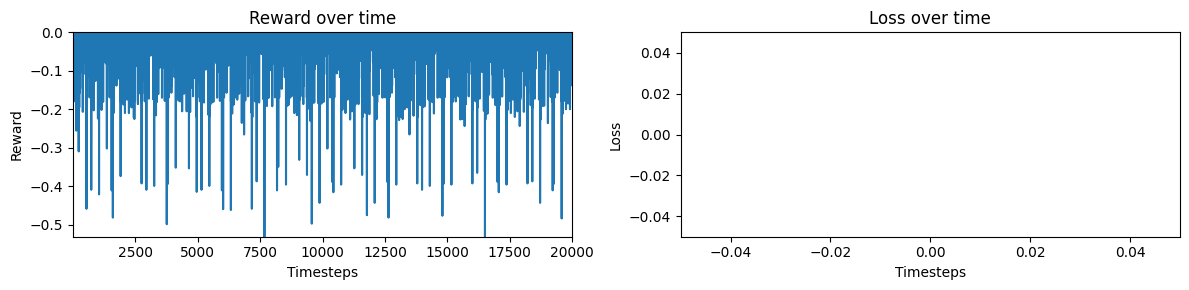

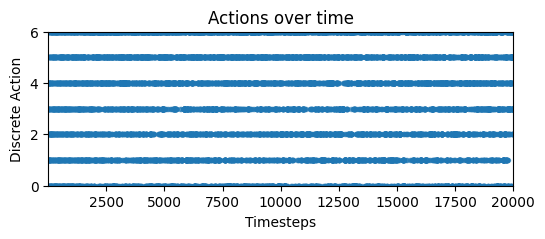

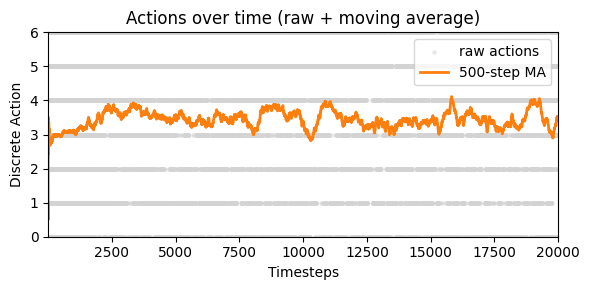

In [46]:
# Reward & Loss Plotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(12,3))
axes[0].plot(df["step"], df["reward"])
axes[0].set_title("Reward over time")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Reward")

axes[1].plot(df["step"], df["loss"])
axes[1].set_title("Loss over time")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

# Actions over time
plt.figure(figsize=(6,2))
plt.plot(df["step"], df["action"], marker=".", linestyle="none", alpha=0.5)
plt.title("Actions over time")
plt.xlabel("Timesteps")
plt.ylabel("Discrete Action")
plt.show()
# Periodic action pattern, maybe due to the 24h cycle of the environment.

# Actions over time with moving average
plt.figure(figsize=(6,3))

# rohdaten
plt.scatter(df["step"], df["action"],
            c="lightgray", s=5, alpha=0.4, label="raw actions")

# rollierender Durchschnitt über z.B. 500 Schritte
window = 500
df["action_ma"] = df["action"].rolling(window=window, min_periods=1).mean()

plt.plot(df["step"], df["action_ma"],
         color="C1", linewidth=2,
         label=f"{window}-step MA")

plt.title("Actions over time (raw + moving average)")
plt.xlabel("Timesteps")
plt.ylabel("Discrete Action")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


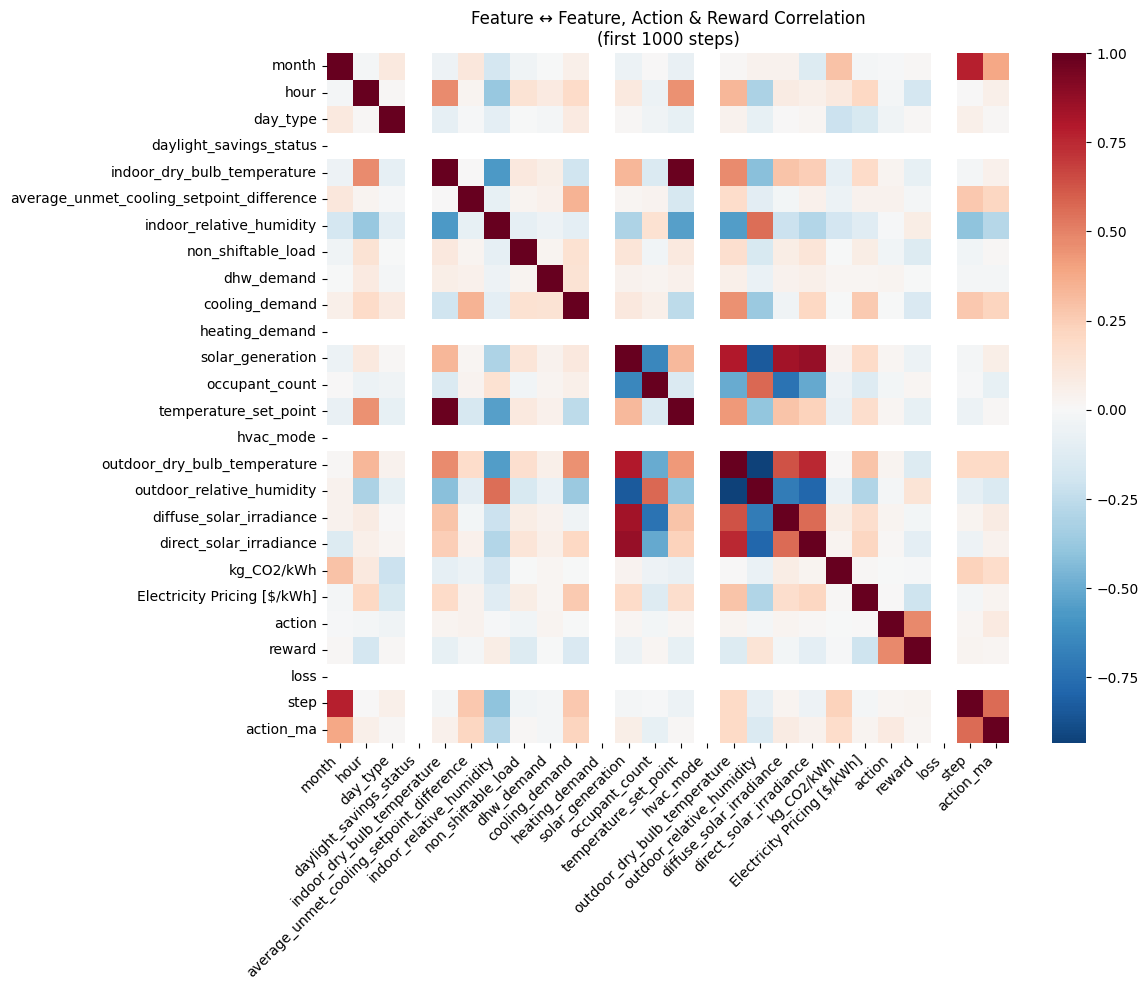

In [47]:
# heatmap of feature correlations
import seaborn as sns

real_labels = [
    'month','hour','day_type','daylight_savings_status',
    'indoor_dry_bulb_temperature',
    'average_unmet_cooling_setpoint_difference',
    'indoor_relative_humidity',
    'non_shiftable_load','dhw_demand',
    'cooling_demand','heating_demand',
    'solar_generation','occupant_count',
    'temperature_set_point','hvac_mode',
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance','direct_solar_irradiance',
    'kg_CO2/kWh','Electricity Pricing [$/kWh]'
]
mapping    = {f"x{i}": real_labels[i] for i in range(len(real_labels))}
mapping.update({"action":"action","reward":"reward"})
df.rename(columns=mapping, inplace=True)

# Zeitfenster
sub = df.iloc[:1000]

# Korrelation berechnen
corr = sub.corr()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    cmap="RdBu_r",
    center=0
)
plt.title("Feature ↔ Feature, Action & Reward Correlation\n(first 1000 steps)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
# Which features are correlated and typically change together?

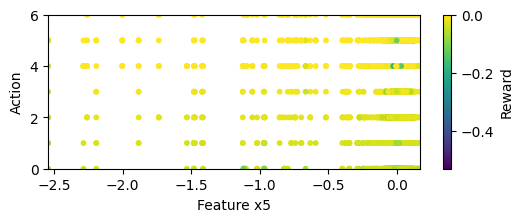

In [48]:
# Plot one feature vs action and reward
plt.figure(figsize=(6,2))
plt.scatter(df["average_unmet_cooling_setpoint_difference"], df["action"], c=df["reward"], cmap="viridis", s=10)
plt.colorbar(label="Reward")
plt.xlabel("Feature x5")
plt.ylabel("Action")
plt.show()

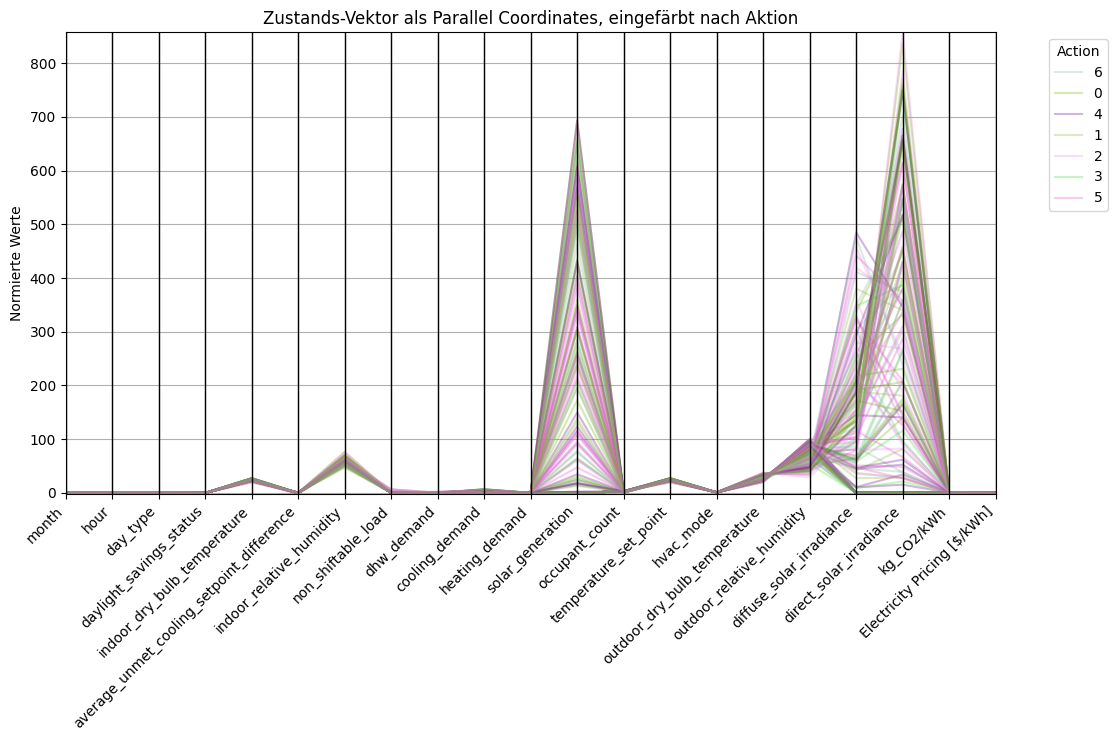

In [49]:
# Parallel Coordinates Plot: color by target action
from pandas.plotting import parallel_coordinates

obs_cols = env.envs[0].unwrapped.obs_cols  # deine Feature-Namen in der richtigen Reihenfolge
rename_map = { f"x{i}": obs_cols[i] for i in range(len(obs_cols)) }
df_named = df.rename(columns=rename_map)

# ich sample hier nur 200 Zeilen, sonst wird’s unübersichtlich
sample = df.sample(200, random_state=0).copy()
# zwing Action als String, damit parallel_coordinates sie als Category behandelt
sample["action"] = sample["action"].astype(str)

plt.figure(figsize=(12,6))
parallel_coordinates(
    sample,
    class_column="action",
    #cols=[f"x{i}" for i in range(len(sample.columns) - 4)],  # x0…xN
    cols=obs_cols,
    alpha=0.3
)
plt.title("Zustands-Vektor als Parallel Coordinates, eingefärbt nach Aktion")
plt.ylabel("Normierte Werte")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Action", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()


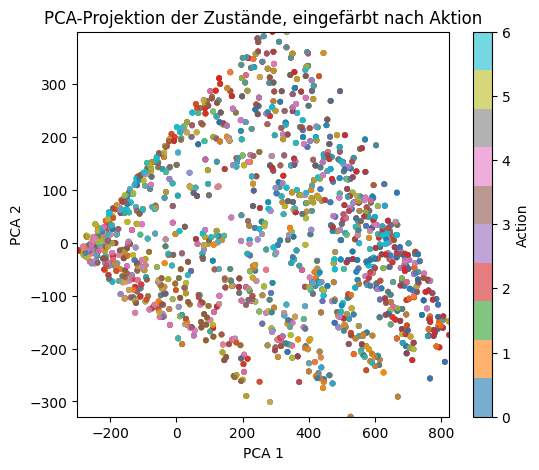

In [50]:
# 1) Mapping von x0…xN auf die echten Feature-Namen
mapping = { f"x{i}": obs_cols[i] for i in range(len(obs_cols)) }
df_renamed = df.rename(columns=mapping)

# 2) Jetzt die Feature-Matrix für PCA extrahieren
X = df_renamed[obs_cols].values  # es gibt jetzt obs_cols Spalten

# 2D PCA Projection of States colored by Action
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
"""
# Features x0…xN
X = df[[c for c in df.columns if c.startswith("x")]].values
pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
"""
plt.figure(figsize=(6,5))
sc = plt.scatter(
    pcs[:,0], pcs[:,1],
    c=df["action"], cmap="tab10",
    s=10, alpha=0.6
)
plt.colorbar(sc, label="Action")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.title("PCA-Projektion der Zustände, eingefärbt nach Aktion")
plt.show()

# 2D PCA Projection of States colored by Reward
# Each point represents a state, colored by the action taken in that state